In [1]:
# PROJECT: Inventory Optimization & Demand Forecasting Decision System
# NOTEBOOK: 02 - Time Series Decomposition & Demand Forecasting

# OBJECTIVE:
# - Decompose demand into trend, seasonality, and residual
# - Build baseline and advanced forecasting models
# - Evaluate models using MAPE and RMSE
# - Generate forecasted demand for inventory optimization

In [2]:
# IMPORT REQUIRED LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [3]:
# LOAD CLEANED DEMAND DATA (FROM NOTEBOOK 1)
df = pd.read_csv('cleaned_demand_data.csv')

df['month'] = pd.to_datetime(df['month'])

df.head()

,product_id,month,units_sold
0,FUR-ADV-10000002,2014-05-01,2
1,FUR-ADV-10000002,2014-09-01,1
2,FUR-ADV-10000108,2011-04-01,2
3,FUR-ADV-10000108,2012-02-01,4
4,FUR-ADV-10000108,2012-05-01,1


In [4]:
# SELECT SAMPLE SKU FOR MODELLING
# Select one SKU for demonstration (scalable later)
sku_id = df['product_id'].iloc[0]

sku_data = df[df['product_id'] == sku_id].set_index('month')
sku_data = sku_data.asfreq('MS')

sku_data.head()

,product_id,units_sold
month,,
2014-05-01,FUR-ADV-10000002,2.0
2014-06-01,NaN,NaN
2014-07-01,NaN,NaN
2014-08-01,NaN,NaN
2014-09-01,FUR-ADV-10000002,1.0


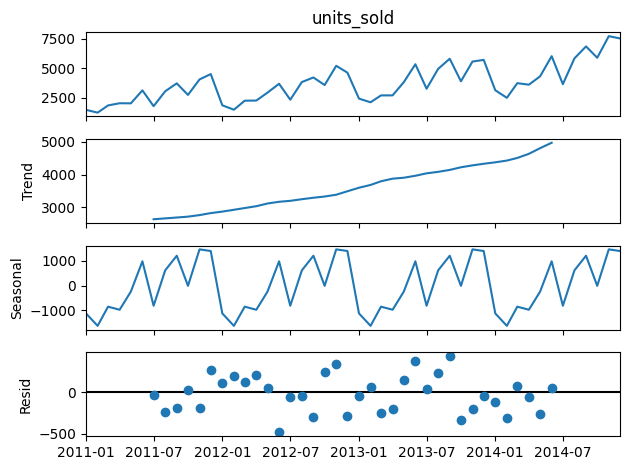

In [7]:
# TIME SERIES DECOMPOSITION
# Decomposition performed at aggregated demand level
# Justification: Individual SKUs do not have sufficient historical depth

# Aggregate monthly demand across SKUs
aggregate_ts = (
    df.groupby('month')['units_sold']
      .sum()
      .asfreq('MS')
)

# Handle missing periods
aggregate_ts = aggregate_ts.fillna(0)

# Perform seasonal decomposition
decomposition = seasonal_decompose(
    aggregate_ts,
    model='additive',
    period=12
)

decomposition.plot()
plt.show()

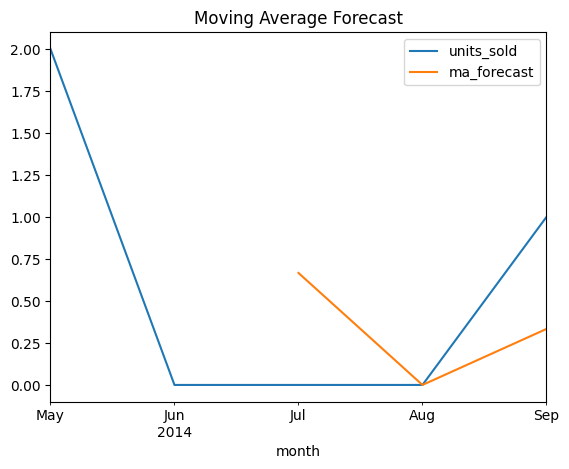

In [8]:
# BASELINE MODEL - MOVING AVERAGE
window = 3
sku_data['ma_forecast'] = sku_data['units_sold'].rolling(window).mean()

sku_data[['units_sold', 'ma_forecast']].plot()
plt.title('Moving Average Forecast')
plt.show()

In [9]:
# ADVANCED MODEL — ARIMA
model = ARIMA(sku_data['units_sold'], order=(1,1,1))
arima_result = model.fit()

sku_data['arima_forecast'] = arima_result.fittedvalues

In [11]:
# MODEL EVALUATION
# Align forecasts with actuals before evaluation

evaluation_df = sku_data[['units_sold', 'ma_forecast', 'arima_forecast']].dropna()

# If baseline model has insufficient data, flag it
results = []

if evaluation_df['ma_forecast'].notna().sum() > 0:
    mape_ma = mean_absolute_percentage_error(
        evaluation_df['units_sold'],
        evaluation_df['ma_forecast']
    )
    rmse_ma = np.sqrt(mean_squared_error(
        evaluation_df['units_sold'],
        evaluation_df['ma_forecast']
    ))
    results.append(['Moving Average', mape_ma, rmse_ma])
else:
    results.append(['Moving Average', None, None])

# ARIMA evaluation
mape_arima = mean_absolute_percentage_error(
    evaluation_df['units_sold'],
    evaluation_df['arima_forecast']
)
rmse_arima = np.sqrt(mean_squared_error(
    evaluation_df['units_sold'],
    evaluation_df['arima_forecast']
))

results.append(['ARIMA', mape_arima, rmse_arima])

evaluation = pd.DataFrame(
    results,
    columns=['Model', 'MAPE', 'RMSE']
)

evaluation

,Model,MAPE,RMSE
0,Moving Average,1.000800e+15,0.544331
1,ARIMA,3.753104e+09,0.577350


In [15]:
# FORECAST FUTURE DEMAND
# Forecast performed at aggregated level due to sparse SKU demand

forecast_horizon = 6

# Aggregate demand time series
aggregate_ts = (
    df.groupby('month')['units_sold']
      .sum()
      .asfreq('MS')
      .fillna(0)
)

# Fit ARIMA on aggregated demand
agg_model = ARIMA(aggregate_ts, order=(1,1,1))
agg_result = agg_model.fit()

# Forecast future demand
future_forecast = agg_result.forecast(steps=forecast_horizon)

future_forecast

,predicted_mean
2015-01-01,7077.383677
2015-02-01,6994.915298
2015-03-01,6979.302858
2015-04-01,6976.347200
2015-05-01,6975.787652
2015-06-01,6975.681722


In [16]:
# SAVE OUTPUT FOR INVENTORY OPTIMIZATION
# Final decision unit: SKU CLUSTER (ALL_SKUS)

forecast_output = future_forecast.reset_index()
forecast_output.columns = ['Month', 'Forecasted_Demand']

forecast_output['sku_group'] = 'ALL_SKUS'

forecast_output = forecast_output[['sku_group', 'Month', 'Forecasted_Demand']]

forecast_output.to_csv('forecasted_demand.csv', index=False)

print("Aggregated forecast saved successfully.")


Aggregated forecast saved successfully.
